In [55]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np


In [56]:

# Transforming images to a pytorch tensor
tensor_transform = transforms.ToTensor()

In [57]:
# Download the MNIST Dataset -> this a dataset where we have images of numbers from 0 to 9 (10 classes)
# and we have 60000 images for training and 10000 images for testing

dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)



torch.Size([32, 1, 28, 28])


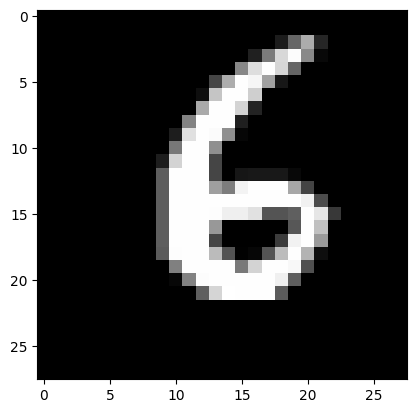

In [58]:
# lets check one of the images
image, label = next(iter(loader))
plt.imshow(image[7].squeeze(), cmap = "gray")
print(image.shape)

In [59]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        self.input_shape = kwargs["input_shape"]
        self.latent_dims = kwargs["latent_dims"]
        self.out_features = 128
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(self.input_shape, self.out_features),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, self.latent_dims) #9
        )
        # [9] 3.88877665... [4.5555...,8.6...
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dims, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.input_shape)
        )




    def forward(self, features):
        encoded = self.encoder(features)
        reconstructed = self.decoder(encoded)
        return reconstructed


In [60]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")


In [61]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using {} device".format(device))

Using mps device


In [62]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=28*28, latent_dims=3).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss() # mean squared error loss ((x - x_hat)**2).sum()

In [63]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)



In [64]:
# Step 1: Assuming you have a validation loader named 'valid_loader'
# set seed
torch.manual_seed(42)
patience = 3  # Number of epochs to wait before stopping
epochs_without_improvement = 0
best_loss = float('inf')  # set initial best loss to infinity
epochs=20
loss_history = []
val_history = []
for epoch in range(epochs):
    # Training loop (as you provided)
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 28*28).to(device) #x
        optimizer.zero_grad()
        outputs = model(batch_features)  #x_hat
        train_loss = criterion(outputs, batch_features) # MSE loss
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()

    loss = loss / len(train_loader)
    print("epoch : {}/{}, training loss = {:.6f}".format(epoch + 1, epochs, loss))
    loss_history.append(loss)

    # Step 2: Validation loop
    model.eval()  # set the model to evaluation mode
    with torch.no_grad(): #we don't use these results to update the model
        val_loss = 0
        for batch_features, _ in valid_loader:
            batch_features = batch_features.view(-1, 784).to(device)
            outputs = model(batch_features)
            val_loss_item = criterion(outputs, batch_features).item()
            val_loss += val_loss_item
        val_loss = val_loss / len(valid_loader)
    print("epoch : {}/{}, validation loss = {:.6f}".format(epoch + 1, epochs, val_loss))
    val_history.append(val_loss)
    # Step 3: Check if this is the best model
    if val_loss < best_loss:
        best_loss = val_loss
        # Save the model (optional but recommended)
        torch.save(model.state_dict(), "best_model.pth")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Step 4: Check for early stopping
    if epochs_without_improvement == patience:
        print("Early stopping!")
        break

    model.train()  # set the model back to training mode

print("Training finished.")


epoch : 1/20, training loss = 0.059686
epoch : 1/20, validation loss = 0.053337
epoch : 2/20, training loss = 0.047993
epoch : 2/20, validation loss = 0.044374
epoch : 3/20, training loss = 0.042800
epoch : 3/20, validation loss = 0.041415
epoch : 4/20, training loss = 0.040550
epoch : 4/20, validation loss = 0.039691
epoch : 5/20, training loss = 0.039292


KeyboardInterrupt: 

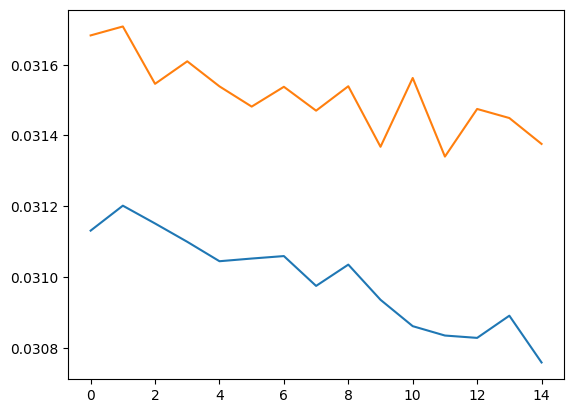

In [23]:
# plot the loss line
plt.plot(loss_history)
plt.plot(val_history)


In [15]:
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
  )
)

In [29]:



def generate_latent_space_representation(model, loader):
    latent_representations = []
    labels = []  # If you have labels and want to color the points based on them

    model.eval()
    with torch.no_grad():
        for batch_features, batch_labels in loader:
            batch_features = batch_features.view(-1, 784).to(device)
            latent_vector = model.encoder(batch_features)  # assuming this method/attribute exists
            latent_representations.append(latent_vector.cpu().numpy())
            labels.append(batch_labels.cpu().numpy())

    latent_representations = np.concatenate(latent_representations, axis=0)
    labels = np.concatenate(labels, axis=0)

    # 2. Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    latent_2D = tsne.fit_transform(latent_representations)

    # 3. Plot the representations
    plt.scatter(latent_2D[:, 0], latent_2D[:, 1], c=labels, cmap='jet')  # coloring based on labels
    plt.colorbar()
    plt.show()
    # save plt as image to disk
    # Save the figure to an image file
    plt.savefig("latent_space_representation_valid.png")
    plt.show()





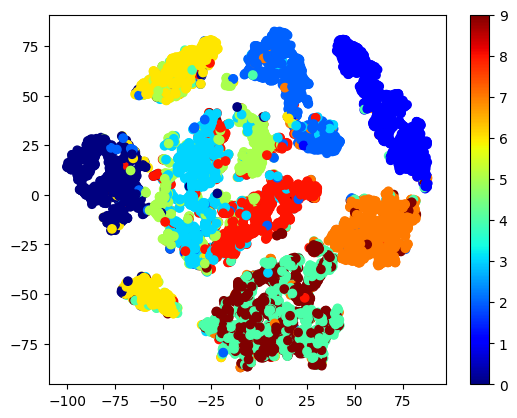

<Figure size 640x480 with 0 Axes>

In [30]:
generate_latent_space_representation(model, valid_loader)

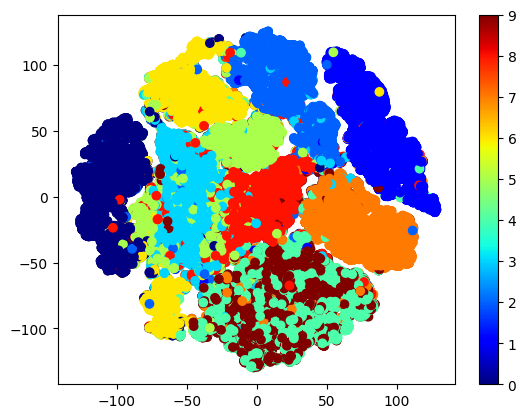

<Figure size 640x480 with 0 Axes>

In [32]:
generate_latent_space_representation(model, train_loader) #training dataset == 60000 images

In [45]:
# Step 1: Assuming you have a validation loader named 'valid_loader'
# create a list of the same images with the reconstructions of their latent space
image_list = []
reconstructed = []
for batch_features, _ in valid_loader:
    image_list.append(batch_features)
    batch_features = batch_features.view(-1, 784).to(device)
    outputs = model(batch_features)
    reconstructed.append(outputs)
    if len(reconstructed) == 10:
        break

image_list

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [46]:
print(image_list[0].shape)
print(reconstructed[0].shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 784])


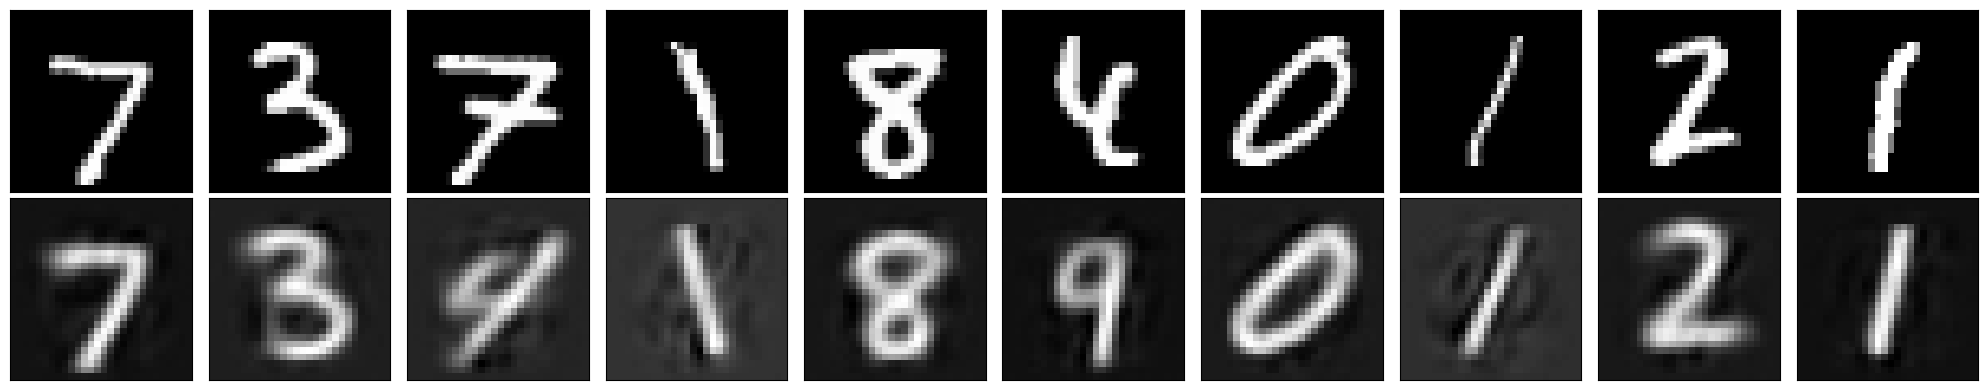

In [53]:
import matplotlib.pyplot as plt

def show_reconstruction_of_images(image_list, reconstructed_images):
    plt.figure(figsize=(20, 4))

    # Plot original images
    for i, image in enumerate(image_list):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(image[0].cpu().numpy().reshape(28, 28), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Plot reconstructed images
    for i, image in enumerate(reconstructed_images):
        ax = plt.subplot(2, 10, i + 11)
        plt.imshow(image[0].cpu().detach().numpy().reshape(28, 28), cmap="gray")  # Move to CPU here
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

# Sample call
# show
show_reconstruction_of_images(image_list, reconstructed)

# FAQ About this code:


Why do we need to use `torch.no_grad()` in the validation loop?

In PyTorch, the optimizer.zero_grad() method is used to clear out the gradients of all parameters that the optimizer is tracking. When we train a neural network, we typically use a technique called backpropagation to compute the gradients of the loss with respect to the model parameters. These gradients are used to update the parameters via the optimizer’s update rule.

Now, why do we need to zero out the gradients before computing the gradients of the current minibatch? When we call the backward() method on the loss tensor, the gradients computed by PyTorch accumulate (i.e., they are added to the existing gradients) for each parameter during each iteration. This is useful when we want to accumulate gradients across multiple batches, but it can lead to incorrect gradient computations when we only want to compute the gradients for a single batch. Therefore, before calling backward() for a new minibatch, we need to zero out the gradients from the previous minibatch. Otherwise, we would be using stale gradients from previous minibatches, which could lead to incorrect parameter updates.


Why do we need to call `model.eval()` before validation?

`Model.eval()` will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode. `torch.no_grad()` impacts the autograd engine and deactivate it.

